# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1B5U8NcfyS0NUT9X29Hm7_J8qZ5BDzOHU

In [62]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [31]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [32]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [33]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [34]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [35]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [36]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [37]:
# For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset
def info_getter(column):
  min_calc = min(subdf[column])
  max_calc = max(subdf[column])
  max_calc = sum(subdf[column])/len(subdf[column])

  print("The minimum", column, "is", min_calc)
  print("The maximum", column, "is", max_calc)
  print("The average", column, "is", max_calc)
  print('\n')

info_getter('age')
info_getter('yredu')
info_getter('capgain')
info_getter('caploss')
info_getter('workhr')

The minimum age is 17
The maximum age is 38.58164675532078
The average age is 38.58164675532078


The minimum yredu is 1
The maximum yredu is 10.0806793403151
The average yredu is 10.0806793403151


The minimum capgain is 0
The maximum capgain is 1077.6488437087312
The average capgain is 1077.6488437087312


The minimum caploss is 0
The maximum caploss is 87.303829734959
The average caploss is 87.303829734959


The minimum workhr is 1
The maximum workhr is 40.437455852092995
The average workhr is 40.437455852092995




In [38]:
# Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1.

# Show the dataset before normalization
print(df[["age", "yredu", "capgain", "caploss", "workhr"]])

# Normalize
df["age"] = (df["age"] - (df["age"]).min())/((df["age"]).max() - (df["age"]).min())
df["yredu"] = (df["yredu"] - (df["yredu"]).min())/((df["yredu"]).max() - (df["yredu"]).min())
df["capgain"] = (df["capgain"] - (df["capgain"]).min())/((df["capgain"]).max() - (df["capgain"]).min())
df["caploss"] = (df["caploss"] - (df["caploss"]).min())/((df["caploss"]).max() - (df["caploss"]).min())
df["workhr"] = (df["workhr"] - (df["workhr"]).min())/((df["workhr"]).max() - (df["workhr"]).min())

# Show dataset after normalization
print(df[["age", "yredu", "capgain", "caploss", "workhr"]])

       age  yredu  capgain  caploss  workhr
0       39     13     2174        0      40
1       50     13        0        0      13
2       38      9        0        0      40
3       53      7        0        0      40
4       28     13        0        0      40
...    ...    ...      ...      ...     ...
32556   27     12        0        0      38
32557   40      9        0        0      40
32558   58      9        0        0      40
32559   22      9        0        0      20
32560   52      9    15024        0      40

[32561 rows x 5 columns]
            age     yredu   capgain  caploss    workhr
0      0.301370  0.800000  0.021740      0.0  0.397959
1      0.452055  0.800000  0.000000      0.0  0.122449
2      0.287671  0.533333  0.000000      0.0  0.397959
3      0.493151  0.400000  0.000000      0.0  0.397959
4      0.150685  0.800000  0.000000      0.0  0.397959
...         ...       ...       ...      ...       ...
32556  0.136986  0.733333  0.000000      0.0  0.377551
32557 

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [39]:
# hint: you can do something like this in pandas
num_males = sum(df["sex"] == " Male")
total_men = (num_males*100)/len(df["sex"])

print("The percentage of people that are males in our dataset is:", total_men, "%")

num_females = sum(df["sex"] == " Female")
total_women = (num_females*100)/len(df["sex"])

print("The percentage of people that are females in our dataset is:", total_women, "%")

The percentage of people that are males in our dataset is: 66.92054912318417 %
The percentage of people that are females in our dataset is: 33.07945087681582 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [40]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [41]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [42]:
print("The number of records containing missing information is: " + str(len(df_with_missing)))
print("The % of records that were removed is: " + str((len(df_with_missing)*100/len(df))) + "%")

The number of records containing missing information is: 1843
The % of records that were removed is: 5.660145572924664%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [43]:
work_type = set()

for x in df_not_missing['work']:
  work_type.add(x)

print("All the possible values of the feature 'work' in df_not_missing are: ")
for i in work_type:
  print(i)

All the possible values of the feature 'work' in df_not_missing are: 
 State-gov
 Self-emp-inc
 Self-emp-not-inc
 Private
 Without-pay
 Local-gov
 Federal-gov


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [44]:
data = pd.get_dummies(df_not_missing)

In [45]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [46]:
len(data.columns)

57

There are 57 columns (features) in the dataframe data. The function, 'get_dummies', transferred strings in the dataset to values of 0 and 1. We now have one column representing each possible outcome for things like work. Now we only need 0s and 1s to represent all the information.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [47]:
datanp = data.values.astype(np.float32)

In [48]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    index = np.where(onehot == onehot.max())[0][0]
    return cat_values[feature][index]

In [49]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [50]:
# Display cat index and cat values that are global
print("Cat_index information:", cat_index)
print("Cat_values information:", cat_values)

Cat_index information: {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
Cat_values information: {'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [51]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
indices = np.arange(len(data))
np.random.shuffle(indices)

first_split = int(len(indices) * 0.70)
second_split = int(len(indices) * 0.85)

train_indices = indices[:first_split]
val_indices = indices[first_split:second_split]
test_indices = indices[second_split:]

train_data = datanp[train_indices]
val_data = datanp[val_indices]
test_data = datanp[test_indices]

print("The length of training data is:", len(train_data))
print("The length of validation data is:", len(val_data))
print("The length of testing data is:", len(test_data))

The length of training data is: 21502
The length of validation data is: 4608
The length of testing data is: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [52]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 30),
            nn.ReLU(),
            nn.Linear(30, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 30), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(30, 57),
            nn.ReLU(),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The Sigmoid activation function in the last step of the decoder forces the output to be in the range 0 to 1 inclusive. This is because we nomralized several columns in the dataframe to have values between 0 and 1; thus, the output of the model should be in this range as well.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [67]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size=128, num_epochs=5, learning_rate=1e-4):
    train_accuracy, val_accuracy, train_loss = [], [], []

    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        i = 1
        for data in train_loader:
            if torch.cuda.is_available():
                data = data.cuda()
                model.cuda()
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i%40 == 0:
                train_accuracy.append(get_accuracy(model, train_loader))
                val_accuracy.append(get_accuracy(model, valid_loader))
                train_loss.append(float(loss)/batch_size)
                print("Epoch:", epoch + 1, ", Iteration:", i, ", Training Accuracy:", train_accuracy[-1], ", Validation Accuracy:", val_accuracy[-1])
            i += 1

    train_accuracy.append(get_accuracy(model, train_loader))
    val_accuracy.append(get_accuracy(model, valid_loader))
    train_loss.append(float(loss)/batch_size)
    print("Epoch:", epoch + 1, ", Training Accuracy:", train_accuracy[-1], ", Validation Accuracy:", val_accuracy[-1])

    # Accuracy Plot
    plt.title("Training and Validation Accuracy")
    plt.plot(train_accuracy, label='Training')
    plt.plot(val_accuracy, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss Plot
    plt.title('Training Loss')
    plt.plot(train_loss, label='Training')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [60]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
          if torch.cuda.is_available():
            item = item.cuda()
            model.cuda()

            inp = item.detach().cpu().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().cpu().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch: 1 , Iteration: 40 , Training Accuracy: 0.42238706476916876 , Validation Accuracy: 0.42042824074074076
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.45718227761758595 , Validation Accuracy: 0.4545355902777778
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.4594301305304933 , Validation Accuracy: 0.4584056712962963
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.4630654512758503 , Validation Accuracy: 0.46263744212962965
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.5475692183672837 , Validation Accuracy: 0.5489728009259259
Epoch: 2 , Iteration: 80 , Training Accuracy: 0.5426937029113571 , Validation Accuracy: 0.5431495949074074
Epoch: 2 , Iteration: 120 , Training Accuracy: 0.5510185099060553 , Validation Accuracy: 0.5516854745370371
Epoch: 2 , Iteration: 160 , Training Accuracy: 0.5671642947942827 , Validation Accuracy: 0.5677083333333334
Epoch: 3 , Iteration: 40 , Training Accuracy: 0.5725358881344371 , Validation Accuracy: 0.5730251736111112
Epoch: 3 , Iteration: 80 , Tr

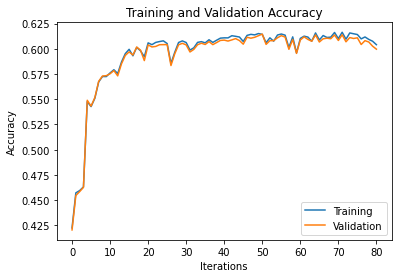

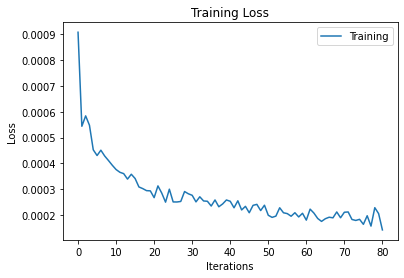

In [68]:
model = AutoEncoder()

if torch.cuda.is_available():
  model.cuda()
else:
  pass

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
train(model, train_loader, valid_loader, batch_size=128, num_epochs=20, learning_rate=0.001)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

Epoch: 1 , Iteration: 40 , Training Accuracy: 0.42238706476916876 , Validation Accuracy: 0.42042824074074076
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.45718227761758595 , Validation Accuracy: 0.4545355902777778
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.4610501348711748 , Validation Accuracy: 0.45949074074074076
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.4609183641831768 , Validation Accuracy: 0.4595630787037037
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5352370322140576 , Validation Accuracy: 0.5368923611111112
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5487163984745606 , Validation Accuracy: 0.5490089699074074
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5613353796546058 , Validation Accuracy: 0.5611617476851852
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.5649784516169039 , Validation Accuracy: 0.5650679976851852
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.5735125414690107 , Validation Accuracy: 0.5740017361111112
Epoch: 2 , Iteration: 80 , 

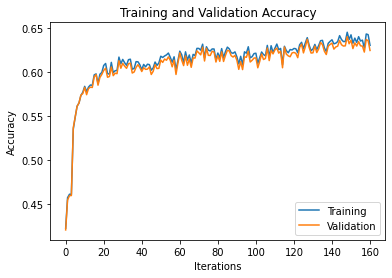

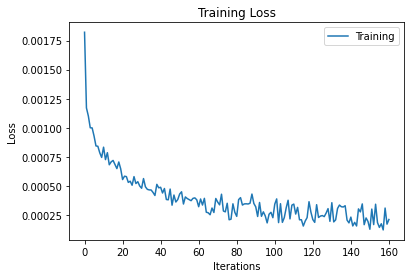

In [69]:
# For the first hyperparameter trial, let's reduce the batch size by 50% and make it 64
second_model = AutoEncoder()

if torch.cuda.is_available():
  second_model.cuda()
else:
  pass

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
train(second_model, train_loader, valid_loader, batch_size=64, num_epochs=20, learning_rate=0.001)

Epoch: 1 , Iteration: 40 , Training Accuracy: 0.4360292065854339 , Validation Accuracy: 0.43627025462962965
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.4592285988900257 , Validation Accuracy: 0.4581886574074074
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.45909682820202774 , Validation Accuracy: 0.45804398148148145
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.549941090751248 , Validation Accuracy: 0.5532045717592593
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5505766905404148 , Validation Accuracy: 0.5528067129629629
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5661178805072397 , Validation Accuracy: 0.5654296875
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5899141165162931 , Validation Accuracy: 0.5877459490740741
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.5944795832945773 , Validation Accuracy: 0.5914713541666666
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.591472111121446 , Validation Accuracy: 0.5892650462962963
Epoch: 2 , Iteration: 80 , Training 

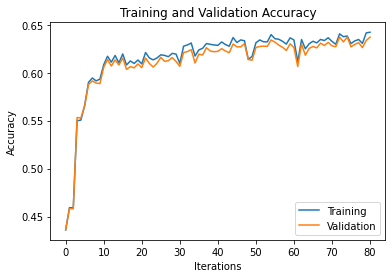

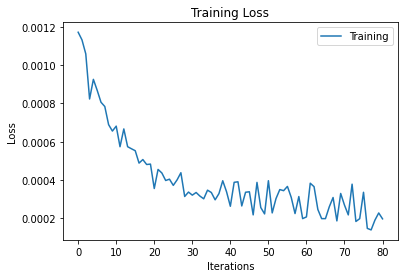

In [70]:
# For the second hyperparameter trial, let's change the learning rate to 0.003
# and decrease number of epochs to 10.
third_model = AutoEncoder()

if torch.cuda.is_available():
  third_model.cuda()
else:
  pass

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
train(third_model, train_loader, valid_loader, batch_size=64, num_epochs=10, learning_rate=0.003)

Epoch: 1 , Iteration: 40 , Training Accuracy: 0.44135429262394194 , Validation Accuracy: 0.4418041087962963
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.534113105757604 , Validation Accuracy: 0.5356264467592593
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.5542662698043593 , Validation Accuracy: 0.5556278935185185
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.5632111741543422 , Validation Accuracy: 0.5638020833333334
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.578752364121167 , Validation Accuracy: 0.5785951967592593
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5695129135274238 , Validation Accuracy: 0.5709635416666666
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5844417573559049 , Validation Accuracy: 0.5821759259259259
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.5872321954546864 , Validation Accuracy: 0.5840205439814815
Epoch: 1 , Iteration: 360 , Training Accuracy: 0.5921619694292004 , Validation Accuracy: 0.5906394675925926
Epoch: 1 , Iteration: 400 , Tra

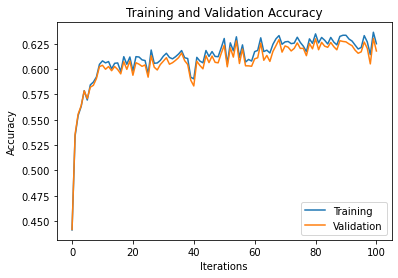

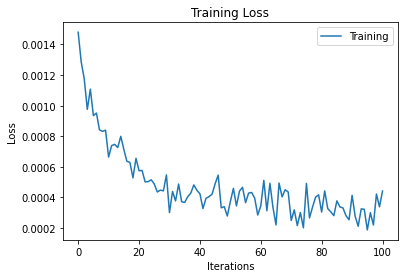

In [71]:
# For the third hyperparameter trial, let's change the learning rate to 0.005
# and batch size to 50 as we keep obtaining good results
fourth_model = AutoEncoder()

if torch.cuda.is_available():
  fourth_model.cuda()
else:
  pass

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=True)
train(fourth_model, train_loader, valid_loader, batch_size=50, num_epochs=10, learning_rate=0.005)

Epoch: 1 , Iteration: 40 , Training Accuracy: 0.463546026726196 , Validation Accuracy: 0.46205873842592593
Epoch: 1 , Iteration: 80 , Training Accuracy: 0.45739931169193565 , Validation Accuracy: 0.4563802083333333
Epoch: 1 , Iteration: 120 , Training Accuracy: 0.5429494930704121 , Validation Accuracy: 0.5450303819444444
Epoch: 1 , Iteration: 160 , Training Accuracy: 0.5483985985799771 , Validation Accuracy: 0.5515769675925926
Epoch: 1 , Iteration: 200 , Training Accuracy: 0.5794887297305678 , Validation Accuracy: 0.5771122685185185
Epoch: 1 , Iteration: 240 , Training Accuracy: 0.5780470033795306 , Validation Accuracy: 0.5776909722222222
Epoch: 1 , Iteration: 280 , Training Accuracy: 0.5946966173689269 , Validation Accuracy: 0.5893012152777778
Epoch: 1 , Iteration: 320 , Training Accuracy: 0.5945105881623415 , Validation Accuracy: 0.5903501157407407
Epoch: 2 , Iteration: 40 , Training Accuracy: 0.6009751030911853 , Validation Accuracy: 0.5962094907407407
Epoch: 2 , Iteration: 80 , Tra

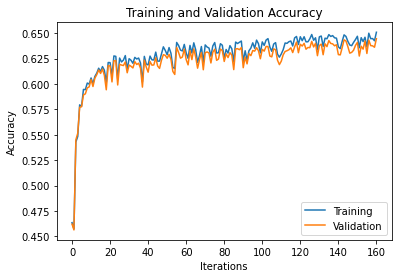

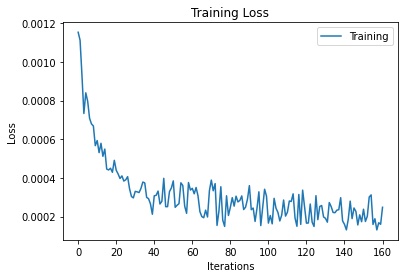

In [72]:
# For the final model, let's use these parameters:
# Batch size = 64
# Learning rate = 0.005
# Epochs = 20
final_model = AutoEncoder()

if torch.cuda.is_available():
  final_model.cuda()
else:
  pass

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
train(final_model, train_loader, valid_loader, batch_size=64, num_epochs=20, learning_rate=0.005)

I elect to use my final_model as comparing it to my other models, it offered me the optimal training and validation accuracy. The highest training accuracy obtained was 65.1% and the highest validation accuracy obtained was 64.5%.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [73]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
test_accuracy = get_accuracy(final_model, test_loader)*100
print("The test accuracy is: " + str(test_accuracy) + "%")

The test accuracy is: 64.77864583333334%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [82]:
most_common_model = {}

for column in df_not_missing.columns:
  most_common_model[column] = df_not_missing[column].value_counts().idxmax()

baseline_accuracy = sum(df_not_missing['marriage'] == most_common_model['marriage'])/len(df_not_missing)

print("The accuracy of the baseline model is: "+ str(baseline_accuracy*100) + "%")

The accuracy of the baseline model is: 46.67947131974738%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

My model has a test accuracy of 64.8% compared to the most common model having an accuracy of 46.7%. I think this is expected as my model looks at all the data and is trained from the training data and optimized by the validation data. Thus, my model performs educated inferences based on patterns seen in the dataset whereas the most common model simply chooses the most frequently used number, ignoring other data.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [83]:
get_features(test_data[0])

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'edu': 'Bachelors',
 'relationship': 'Not-in-family',
 'sex': 'Male'}

No I don't think it's reasonable for a human to guess this individual's education level based on the other features. Humans make assumptions about one's education level based on their current career and status. The person in the dataset is a professor so I think most people would assume they completed a PhD degree to become a professor and not just a bachelor's as professors are notorious for going through riguorous schooling. Due to this assumption, I think a human would guess their bachelor's education level incorrectly.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [86]:
first_data = test_data[0]

education_first_index = cat_index['edu']
education_last_index = cat_index['edu'] + len(cat_values['edu'])

first_data[education_first_index:education_last_index] = 0
first_data = torch.from_numpy(first_data)
first_data = first_data.cuda()

model_pred = final_model(first_data)
model_pred = model_pred.detach().cpu().numpy()

print("My model predicts that this person's education is: " + str(get_feature(model_pred, "edu")))

My model predicts that this person's education is: Bachelors


My model correctly predicts that the person's education level given their other features is Bachelors. 

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [81]:
baseline_pred = df_not_missing['edu'].value_counts().idxmax()
print("The baseline model's prediction for this person's education is:" + str(baseline_pred))

The baseline model's prediction for this person's education is: HS-grad


In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb